# Quantum Compiling

This Jupiter notebook shows some examples of my quantum compiler prototype implemented for the Seminar "Advanced Topics in Quantum Computing" in the Summer Semester 2023.

In [7]:
from compiler import Circuit, Gate
import numpy as np
import qiskit
%load_ext autoreload
%autoreload 2

## Gate decomposition

Our goal is to decompose any gate to a set of gates that is supported by the hardware. We consider the following set of gates: controlled NOT gate, Z rotations, X and SX gate. These gates are the native gates of most of the IBM computers.

### Multiple qubit gate decomposition

Quantum computers can only execute gates with at most one control qubit. Therefore multiple controlled gates need to be decomposed to single control gates. 

This can be done by recursively decomposing a n-controlled gate to a (n-1)-controlled gates.

Here for example is the decomposition of the Toffoli gate to CNOT gates and controlled SX gates.

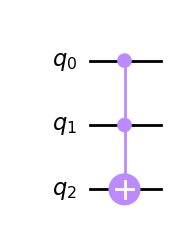

In [2]:
toffoli_decomposition = Circuit(3)
toffoli_decomposition.toffoli(0, 1, 2)
toffoli_decomposition.qiskit_draw2()

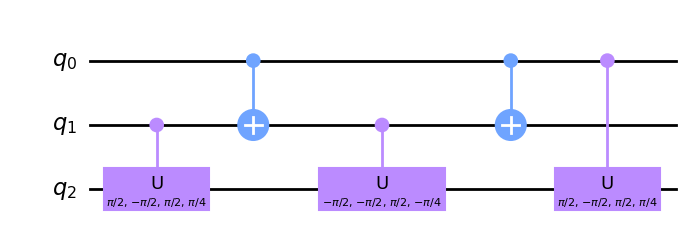

In [3]:
toffoli_decomposition.gates = toffoli_decomposition.gates[0]._decompose_multiple_qubit_gates()
toffoli_decomposition.qiskit_draw2()

#### Decompose single controlled gate

The only controlled gate supported by the hardware is the controlled NOT gate, therefore we must decompose the controlled SX gate even further.

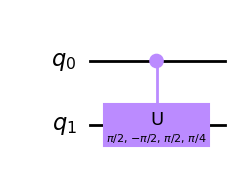

In [5]:
controlled_sx = Circuit(2)
controlled_sx.ssx(1, [0], 1)
controlled_sx.qiskit_draw2()


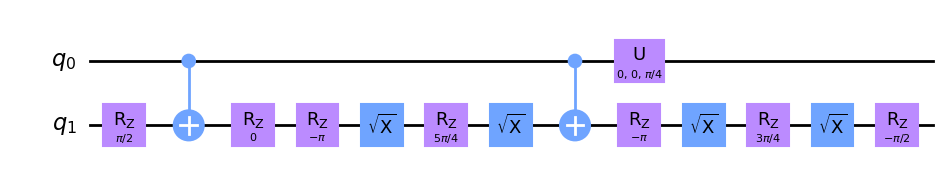

In [6]:
controlled_sx.gates = controlled_sx.gates[0]._decompose_to_cx_rz_u()
controlled_sx.qiskit_draw2()

#### Decompose single qubit gate

Now the only thing that is missing is to decompose an arbitrary single qubit gate to the native gates.

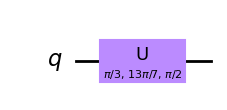

In [7]:
u_gate = Circuit(1)
# an example U gate
u_gate.u(0, np.pi/3, -np.pi/7, np.pi/2, np.pi)
u_gate.qiskit_draw2()


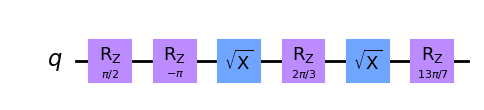

In [8]:
u_gate.gates = u_gate.gates[0]._decompose_u_gate()
u_gate.qiskit_draw2()

## Qubit routing

In physical quantum computers, not all qubits are connected with each other. Especially in the current NISQ era, the connectivity of the qubits is still very low. In order to execute a quantum circuit, the virtual qubits need to be mapped to the physical qubits such that the interacting qubits are mapped to qubits that are adjacent in the physical architecture. It's not always possible to find such a perfect mapping from virtual qubits to physical qubits, which allows all the two-qubit gates to be executed. Therefore the compiler must also add swap operations in the middle of the circuit, in order to move interacting qubits to a position where they are adjacent. 

The goal of the compiler is to build an equivalent executable circuit with the minimal number of gates and qubits used, in order to minimize the error of the execution on the quantum computer. The problem of finding the optimal mapping and the minimum number of swap operations needed is NP-complete, therefore there are some exponential search algorithms and heuristic implementations of the routing problem.

Note: my implementation of the routing assumes that if two qubits are connected, then they can interact in both directions. 
This is not always the case in physical quantum computers.
However, in the available IBM quantum computers, this is always the case.

### Find initial mapping

IBMQ Lima: 

![Coupling map of IBMQ Lima](images/ibmq_lima.png)

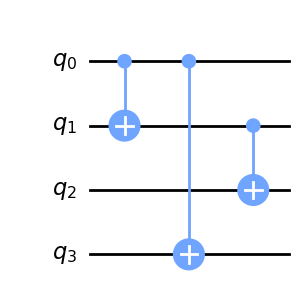

In [9]:
# define circuit
initial_mapping_circuit = Circuit(4)
initial_mapping_circuit.cnot(0,1)
initial_mapping_circuit.cnot(0,3)
initial_mapping_circuit.cnot(1,2)
initial_mapping_circuit.qiskit_draw2()


([1, 3, 4, 0], [1, 3, 4, 0])


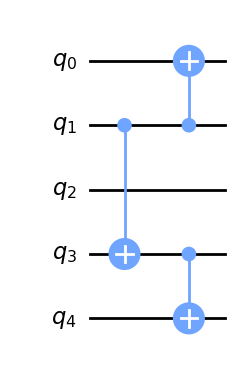

In [10]:
# map circuit to IBMQ Lima
ibmq_lima_coupling_map = [[0,1],[1,0],[1,2],[2,1],[1,3],[3,1],[3,4],[4,3]]

print(initial_mapping_circuit.route(ibmq_lima_coupling_map, 5))
initial_mapping_circuit.qiskit_draw2()

### Add necessary swaps

The swap instruction is directly decomposed to three CNOTs.

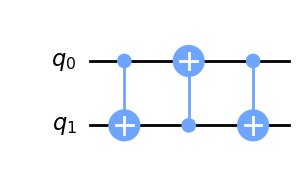

In [11]:
swap_decomposition = Circuit(2)
swap_decomposition.swap(0,1)
swap_decomposition.decompose()
swap_decomposition.qiskit_draw2()

The $route()$ function returns the initial mapping of qubits and the final mapping at the end of the circuit.

IBMQ Manila:

![Coupling map of IBMQ Manila](images/ibmq_manila.png)

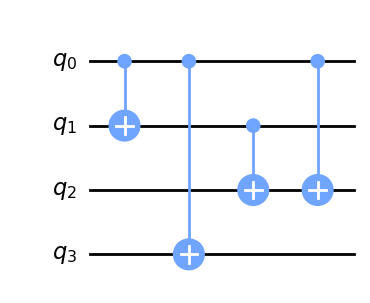

In [13]:
# define circuit
routing_circuit = Circuit(4)
routing_circuit.cnot(0,1)
routing_circuit.cnot(0,3)
routing_circuit.cnot(1,2)
routing_circuit.cnot(0,2)
routing_circuit.qiskit_draw2()


Initial mapping: [1, 2, 3, 0]
Final mapping: [2, 1, 3, 0]


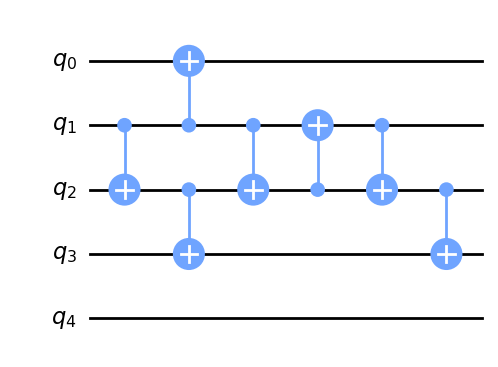

In [14]:
# route circuit
ibmq_manila_coupling_map = [[0,1],[1,0],[1,2],[2,1],[2,3],[3,2],[3,4],[4,3]]

initial_mapping, final_mapping = routing_circuit.route(ibmq_manila_coupling_map, 5)
print("Initial mapping: " + str(initial_mapping))
print("Final mapping: " + str(final_mapping))
routing_circuit.qiskit_draw2()

## Optimization

Three simple optimizations are supported by the compiler: removal of adjacent inverse gates, removal of rotations by $2\pi$ degrees, and merging of consecutive rotations.

### Remove adjacent inverse gates

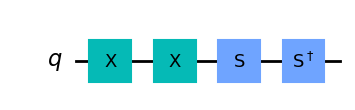

In [21]:
x_x = Circuit(1)
x_x.x(0)
x_x.x(0)
x_x.s(0)
x_x.sdg(0)
x_x.qiskit_draw2()

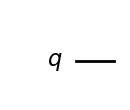

In [22]:
x_x.optimize()
x_x.qiskit_draw2()

### Remove null rotations

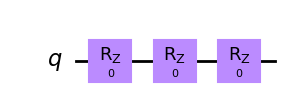

In [23]:
rz_circuit = Circuit(1)
rz_circuit.rz(0, 0)
rz_circuit.rz(0, 2*np.pi)
rz_circuit.rz(0, 4*np.pi)
rz_circuit.qiskit_draw2()

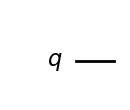

In [24]:
rz_circuit.optimize()
rz_circuit.qiskit_draw2()

### Merge rotations

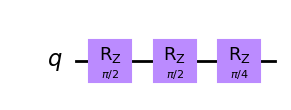

In [25]:
rz_circuit2 = Circuit(1)
rz_circuit2.rz(0, np.pi/2)
rz_circuit2.rz(0, np.pi/2)
rz_circuit2.rz(0, np.pi/4)
rz_circuit2.qiskit_draw2()

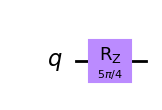

In [26]:
rz_circuit2.optimize()
rz_circuit2.qiskit_draw2()

## Examples

### Three qubit Fourier transformation

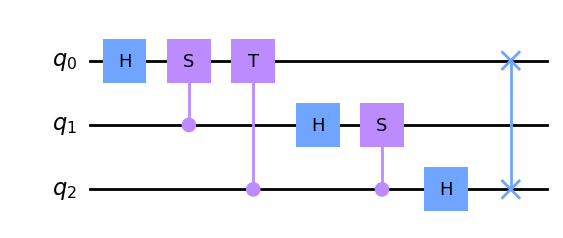

In [19]:
# define circuit
fourier = Circuit(3)
fourier.h(0)
fourier.cs(1, 0)
fourier.ct(2, 0)
fourier.h(1)
fourier.cs(2, 1)
fourier.h(2)
fourier.swap(0, 2)
fourier.qiskit_draw2()

#### Gate decomposition

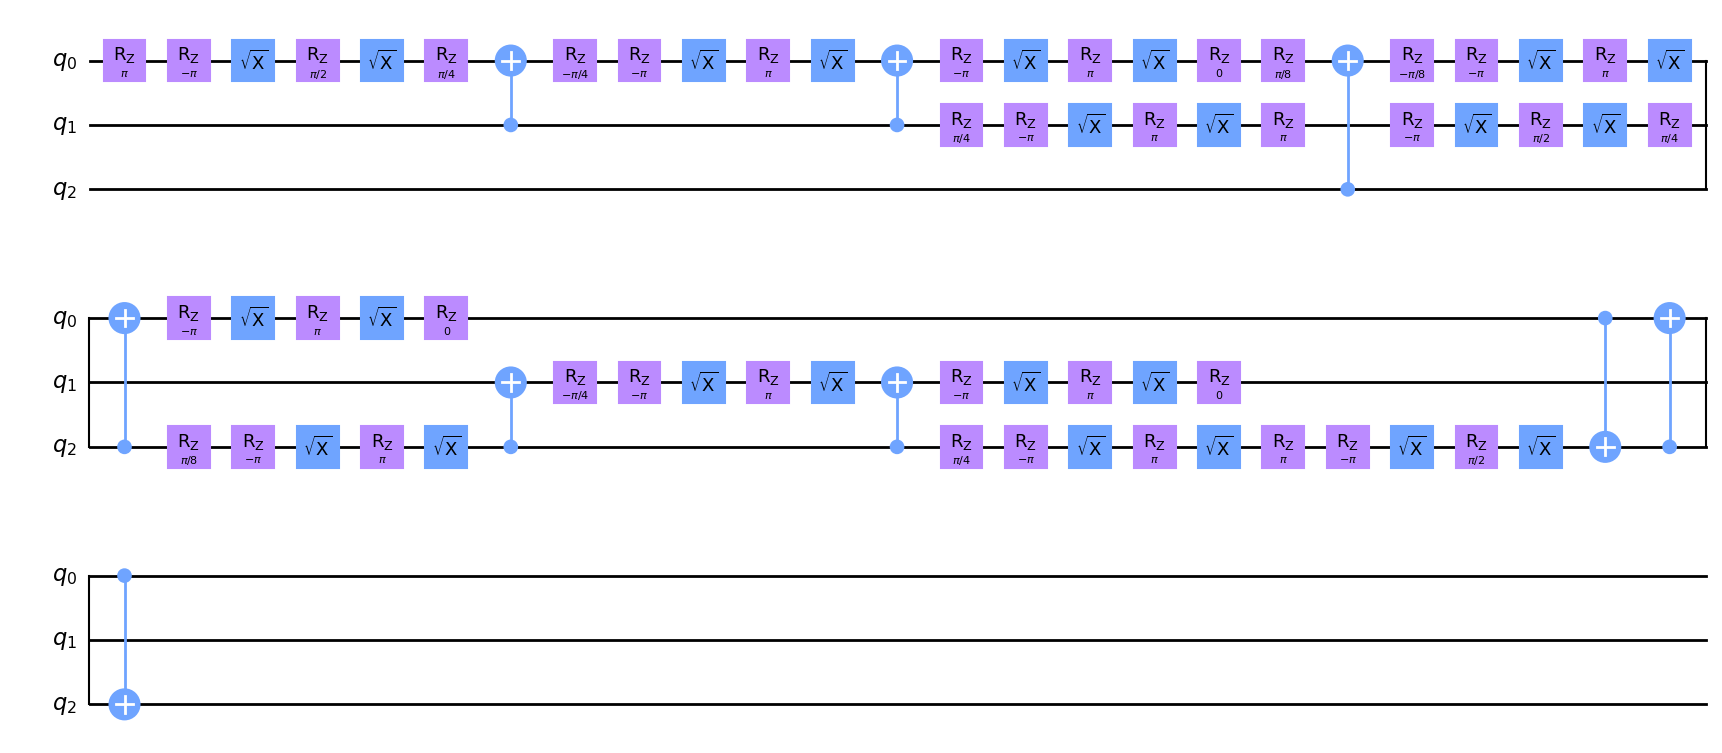

In [20]:
fourier.decompose()
fourier.qiskit_draw2()

#### Circuit optimization

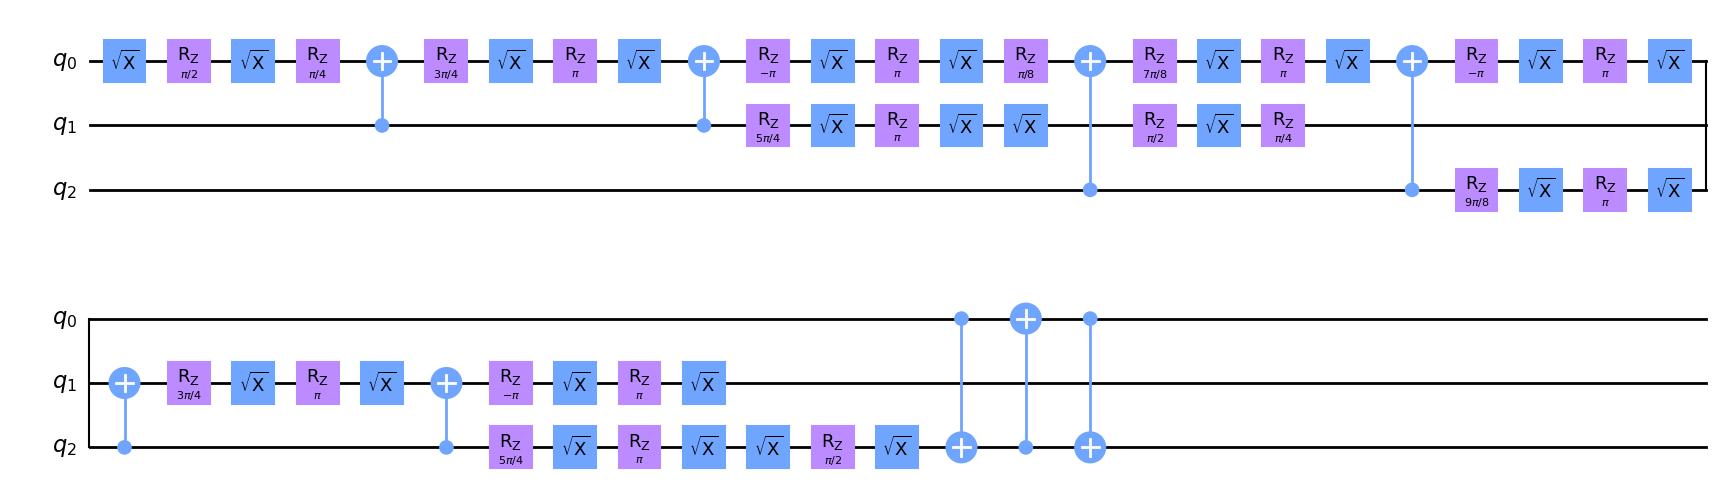

In [21]:
fourier.optimize()
fourier.qiskit_draw2()

### Qubit routing

Initial mapping: [1, 3, 4]
Final mapping: [1, 4, 3]


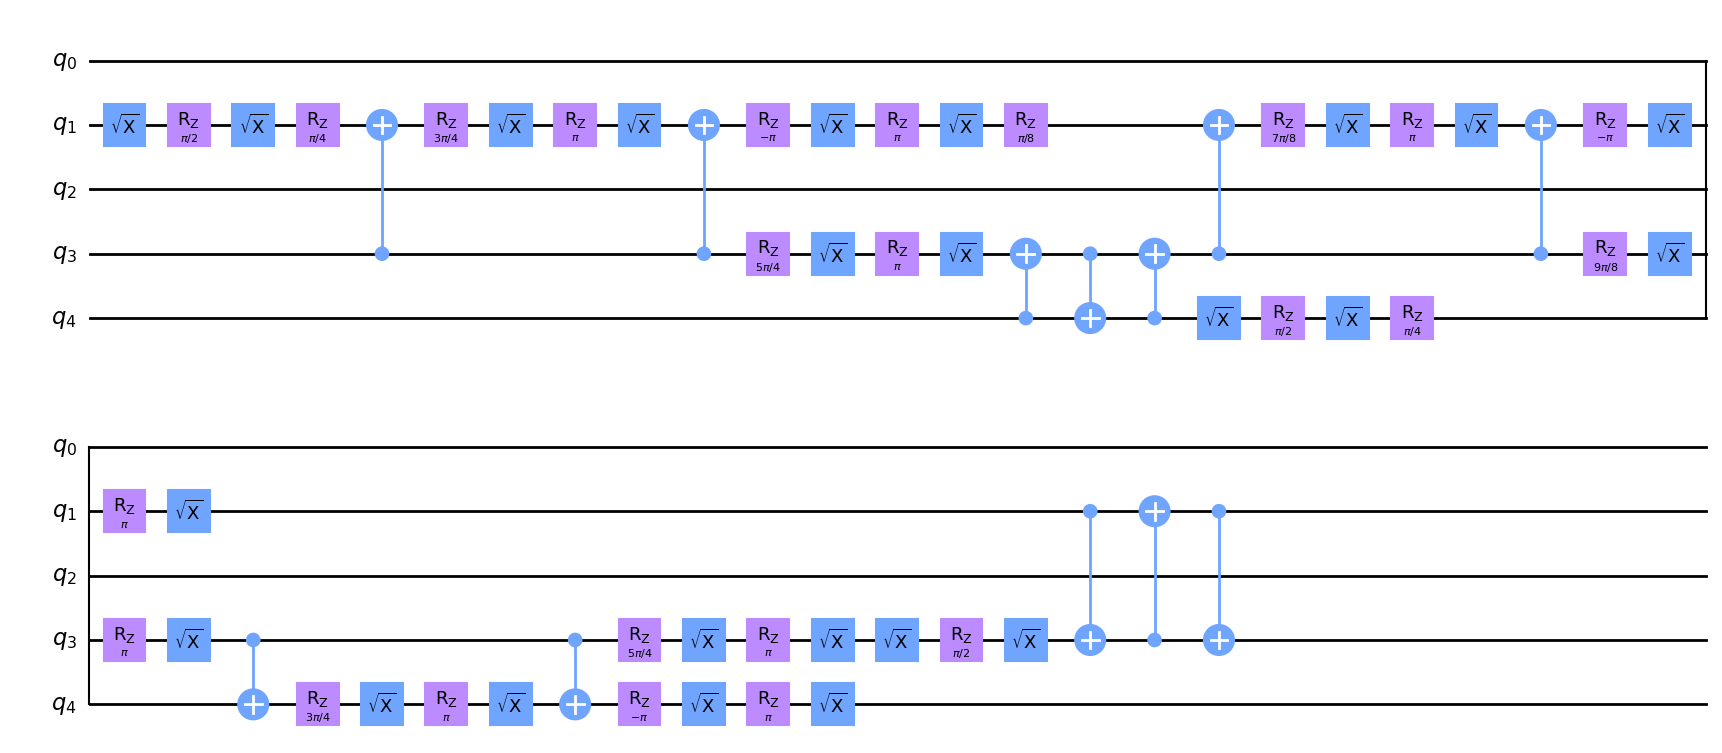

In [22]:
initial_mapping, final_mapping = fourier.route(ibmq_lima_coupling_map, 5)
print("Initial mapping: " + str(initial_mapping))
print("Final mapping: " + str(final_mapping))
fourier.qiskit_draw2()

### Comparison with Qiskit

State-of-the-art quantum compilers, like Qiskit, implement more sophisticated algorithms for compilation, yielding smaller circuits, as is shown by this simple example:

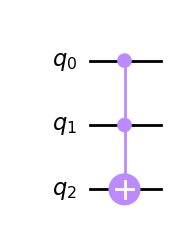

In [26]:
toffoli_circuit = Circuit(3)
toffoli_circuit.ccx(0,1,2)
toffoli_circuit.qiskit_draw2()

Gate count: 46


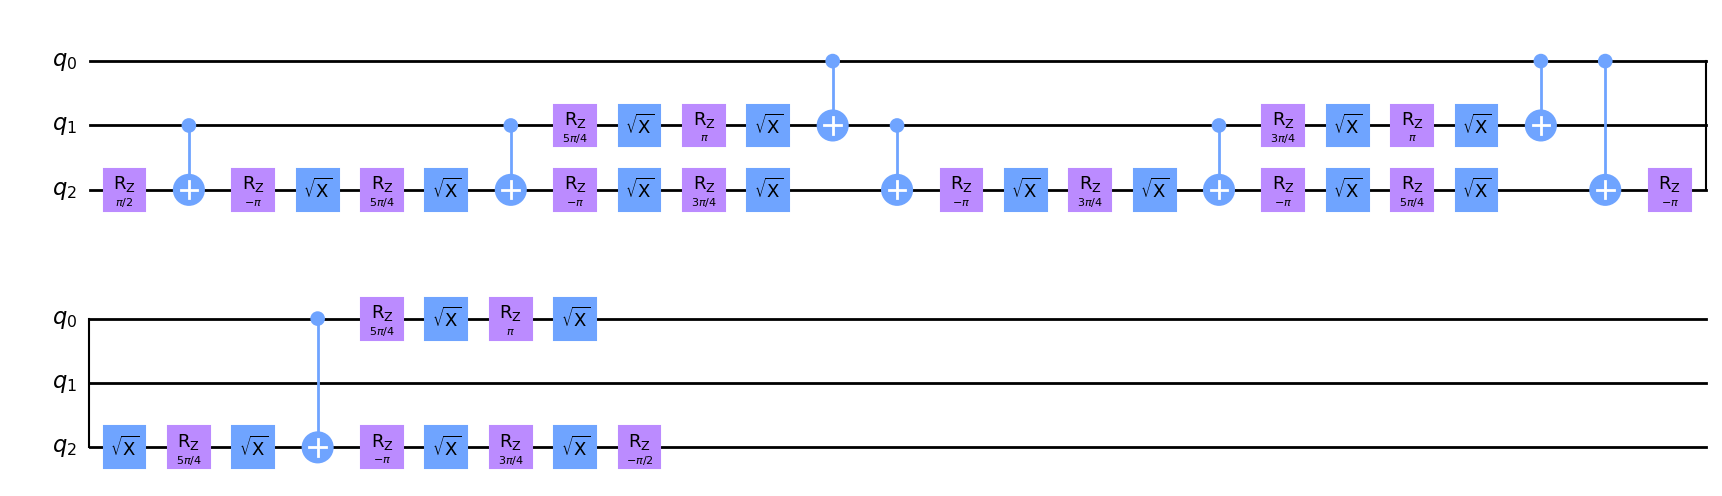

In [27]:
toffoli_circuit.decompose()
toffoli_circuit.optimize()
print("Gate count: " + str(len(toffoli_circuit.gates)))
toffoli_circuit.qiskit_draw2()

Gate count: 18


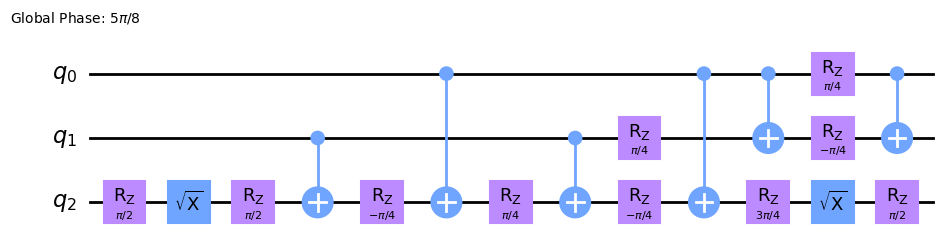

In [42]:
qiskit_toffoli = qiskit.QuantumCircuit(3)
qiskit_toffoli.ccx(0,1,2)
qiskit_toffoli = qiskit.transpile(qiskit_toffoli, basis_gates=['cx', 'rz', 'x', 'sx'])
print("Gate count: " + str(sum([count for (gate, count) in qiskit_toffoli.count_ops().items()])))
qiskit_toffoli.draw('mpl')

## Testing

The file `compiler/test.py` contains a few useful functions to test if two circuits are equivalent.

In [34]:
from compiler import circuit_to_matrix, are_equal_ignore_phase

# test if the toffoli gate decomposition yields a correct circuit
circuit = Circuit(3)
circuit.ccx(0, 1, 2)
matrix1 = circuit_to_matrix(circuit)
circuit.decompose()
matrix2 = circuit_to_matrix(circuit)
print(are_equal_ignore_phase(matrix1, matrix2))

True


The file `test_main.py` runs all the tests defined in the folder `test/`.

## Simulation

There is a function to simulate the execution of the circuits using qiskit's aer_simulator.

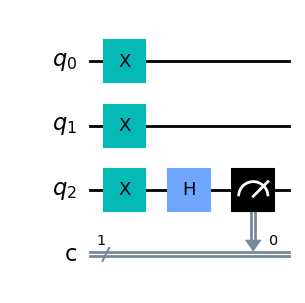

In [8]:
from qiskit.tools.visualization import plot_histogram

# define circuit
circ = Circuit(3)
circ.x(0)
circ.x(1)
circ.x(2)
circ.h(2)
circ.measure(2)
circ.qiskit_draw2()


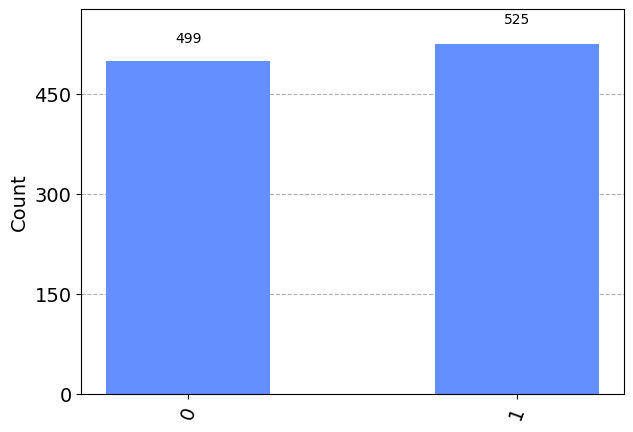

In [9]:
# simulate
counts = circ.simulate()
plot_histogram(counts)

## Execution on quantum hardware

The circuit can also be executed on real quantum hardware. The code for the execution only works if you have an [IBM Quantum account saved on your disk](https://qiskit.org/ecosystem/ibm-provider/stubs/qiskit_ibm_provider.IBMProvider.html). Therefore the code is commented out for the moment.


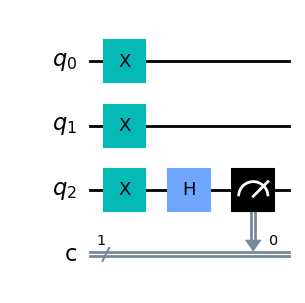

In [10]:
# define circuit
circ = Circuit(3)
circ.x(0)
circ.x(1)
circ.x(2)
circ.h(2)
circ.measure(2)
circ.qiskit_draw2()


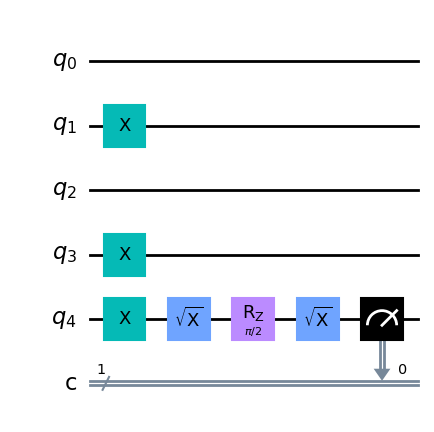

In [12]:
ibmq_lima_coupling_map = [[0,1],[1,0],[1,2],[2,1],[1,3],[3,1],[3,4],[4,3]]

circ.compile(ibmq_lima_coupling_map, 5)

circ.qiskit_draw2()


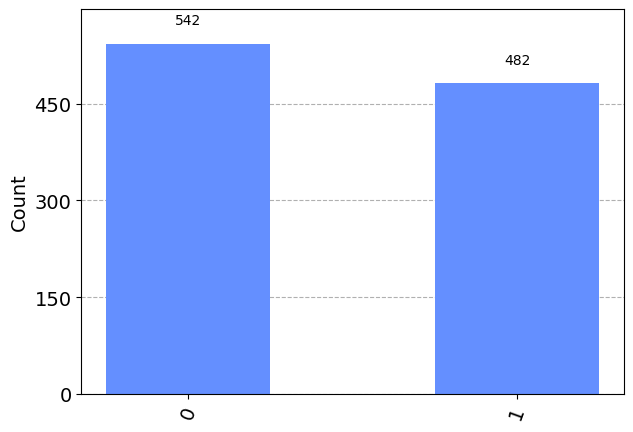

In [15]:
# from qiskit_ibm_provider import IBMProvider
# provider = IBMProvider()

# device = provider.get_backend('ibmq_lima')

# circ_q = circ.to_qiskit_circuit()
# job = device.run(circ_q, shots=1024)
# result = job.result()
# counts = result.get_counts(circ_q)

# plot_histogram(counts)

## Conclusion

After the decomposition of the gates and the routing to the physical qubits, the circuit is ready to be directly executed by a quantum computer. 

The algorithms for finding mappings to hardware and decompose circuits can be optimized in order to yield shorter circuits in the end. 
This is important, because the less gates there are in the circuit, the less errors are accumulated by the execution on the quantum computer. This is especially indispensable in the current NISQ era. 

